In [2]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

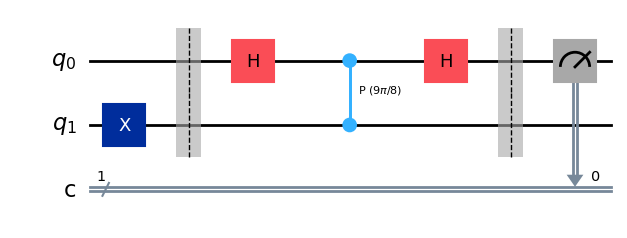

In [9]:
qc = QuantumCircuit(2,1)

qc.x(1)
qc.barrier()
qc.h(0)
qc.cp(9*pi/8,0,1)
qc.h(0)
qc.barrier()
qc.measure(0,0)
qc.draw("mpl")



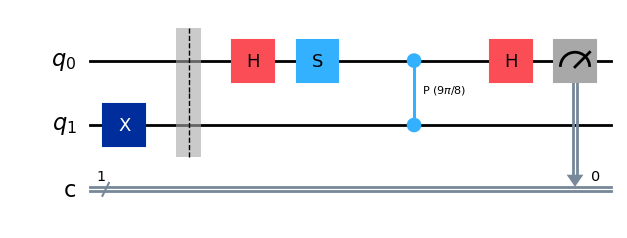

In [10]:
qc2 = QuantumCircuit(2,1)
qc2.x(1)
qc2.barrier()
qc2.h(0)
qc2.s(0)
qc2.cp(9*pi/8,0,1)
qc2.h(0)
qc2.measure(0,0)
qc2.draw("mpl")

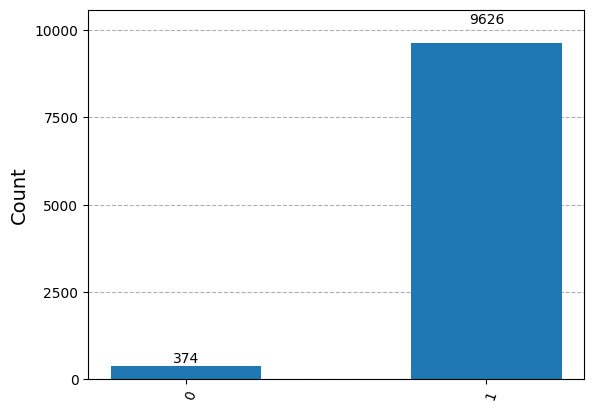

In [11]:
backend = BasicSimulator()

# If you do not specify the number of shots, the default is 1024
result = backend.run(qc, shots=10000).result()   

# Extract the counts of 0 and 1 measurements
counts = result.get_counts()                    
plot_histogram(counts)

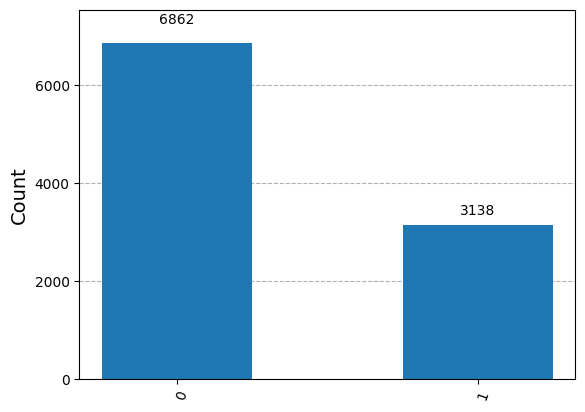

In [6]:
# If you do not specify the number of shots, the default is 1024
result2 = backend.run(qc2, shots=10000).result()   

# Extract the counts of 0 and 1 measurements
counts2 = result2.get_counts()                    
plot_histogram(counts2)

In [31]:
print(counts)
re = -((2*counts['1']/10000)-1)
im = (2*counts2['1']/10000)-1
phi1 = np.arccos(re)
phi2 = np.arcsin(im)
print(re,im)
print(phi1,phi2)
compnum = complex(phi1, phi2)
print(compnum)
print(np.angle(compnum))
a = np.arctan(phi2/phi1)
print(a)

{'1': 9626, '0': 374}
-0.9252 -0.37239999999999995
2.7523586198413312 -0.3815936886112235
(2.7523586198413312-0.3815936886112235j)
-0.13776422137376293
-0.1377642213737629
